# Hands-on: Simultaneous least squares fit (blast-wave fit to $\pi$, $K$, $p$ spectra in  Pb-Pb collisions)

Transverse momentum spectra in high-energy Pb-Pb collisions can be describes by a superposition of thermal sources who move with a velocity $\beta$ towards the detector. The functional form is given by

$$
\frac{1}{2 \pi p_T}\frac{dN}{dp_T dy} \propto m_T \int_{0}^{1} \hat r d \hat r I_0\left(\frac{p_T \sinh\rho(\hat r)}{T}\right) K_1\left(\frac{m_T \cosh\rho(\hat r)}{T}\right) 
$$

where $I_0$ and $K_1$ are modified Bessel functions. Here $T$ is the (kinetic) freeze-out temperature. The transverse mass is defined as $m_T = \sqrt{p_T^2 + m^2}$. The transverse velocity depends and the radial coordinate $r$ as 

$$
\beta(\hat r) = \beta_s {\hat r}^n \equiv \beta_s \left( \frac{r}{R} \right)^n
$$

where $\beta_s$ is the velocity at the surface of the fireball (maximum radial distance $R$).

In this problem we perform a simultaneous fit to pion, kaon, and proton transverse momentum spectra in central (0-5\%) Pb-Pb collisions at 5.02 TeV center-of-mass energy (per nucleon-nucleon pair) in order to extract the model parameters $T$, $\beta_s$, and $n$.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import k1
from scipy.special import i0
from iminuit import Minuit

In [64]:
# define blast-wave integrand (the term we have to integrate over radial coordinate r)
def dndpt_blastwave_integrand(r, pt, m, Tkin, beta_s, n):
    beta = beta_s * np.power(r, n)
    rho = np.arctanh(beta)
    mt = np.sqrt(m * m + pt * pt)
    xip = pt * np.sinh(rho) / Tkin
    xim = mt * np.cosh(rho) / Tkin
    return 2. * np.pi * pt * r * mt * i0(xip) * k1(xim)

In [65]:
def dndpt_blastwave_scalar(pt, m, Tkin, beta_s, n):
    integral, integral_err = integrate.quad(lambda r: dndpt_blastwave_integrand(r, pt, m, Tkin, beta_s, n), 0, 1.)
    return integral
dndpt_blastwave = np.vectorize(dndpt_blastwave_scalar) # can be used we numpy arrays

a) Plot the blast-wave $p_T$ spectrum for protons for two differnt surface velocities $\beta_s = 0.2$ and $\beta_s = 0.8$ in the range $0 \le p_T \le 3\,\mathrm{GeV}/c$. Use $T = 0.1\,\mathrm{GeV}$ and $n = 1.$

In [66]:
mp = 0.938 # proton mass in GeV
Tk = 0.1 # kinetic freeze-out temperature in GeV
n = 1

pt = np.linspace(0., 3., 100)
dndpt_1 = dndpt_blastwave(pt, mp, Tk, 0.2, n);
# ...

# your code here


In [67]:
# read pion, kaon, and proton pT spectra in 0-5% Pb-Pb collisions at 5.02 TeV
pt = {}
dndpt = {}
dndpt_err = {}
pt["pion"], dndpt["pion"], dndpt_err["pion"] = np.loadtxt("../data/HEPData-1569102768-v1-csv/Table1.csv", delimiter=',', usecols=(0,3,6), unpack=True, skiprows=12, max_rows=58)
pt["kaon"], dndpt["kaon"], dndpt_err["kaon"] = np.loadtxt("../data/HEPData-1569102768-v1-csv/Table3.csv", delimiter=',', usecols=(0,3,6), unpack=True, skiprows=12, max_rows=53)
pt["proton"], dndpt["proton"], dndpt_err["proton"] = np.loadtxt("../data/HEPData-1569102768-v1-csv/Table5.csv", delimiter=',', usecols=(0,3,6), unpack=True, skiprows=12, max_rows=52)

In [68]:
# dictionaries for pt fit ranges for each particle and particle masses 
pt_min = {"pion": 0.5, "kaon": 0.2, "proton": 0.3}
pt_max = {"pion": 1.0, "kaon": 1.5, "proton": 3.0}
mass = {"pion": 0.139, "kaon": 0.494, "proton": 0.938}

In [69]:
# prepare data in selected pt ranges
pt_meas = {}
dndpt_meas = {}
dndpt_meas_err = {}
for particle in ["pion", "kaon", "proton"]:
    sel = (pt[particle] >= pt_min[particle]) & (pt[particle] <= pt_max[particle])
    pt_meas[particle] = pt[particle][sel]
    dndpt_meas[particle] = dndpt[particle][sel]
    dndpt_meas_err[particle] = dndpt_err[particle][sel]

We take the normalization of the blast-wave function as an arbitrary parameter that we adjust in the fit range for a given set of blast-wave parameters $T$, $\beta_s$, and $n$. You can convice yourself that a simple least squares minimization gives the following formula for the normalization (factor in front of the blast-wave formula):

$$
A = \frac{\sum_i \frac{y_i^\mathrm{data} y_i^\mathrm{BW}}{\sigma_i^2}}{\sum_i \frac{ {y_i^\mathrm{BW}}^2 }{\sigma_i^2} }
$$

This is implemented in the function 'normalization' (see below).

In [70]:
# calculate normalization of the blastwave function for given blastwave parameters and particle species
def normalization(particle, Tkin, beta_s, n):
    dndpt_bw = dndpt_blastwave(pt_meas[particle], mass[particle], Tkin, beta_s, n)
    err_square = dndpt_meas_err[particle]**2
    A_num = np.sum((dndpt_meas[particle] * dndpt_bw) / err_square)
    A_den = np.sum(dndpt_bw**2 / err_square)
    return A_num / A_den    

b) Implement a function the returns the $\chi^2$ for a given particle species

In [71]:
# chi2 for a given particle species
def chi2_particle(particle, Tkin, beta_s, n):

    # blast-wave prediction
    dndpt_bw = dndpt_blastwave(pt_meas[particle], mass[particle], Tkin, beta_s, n)

    # normalization
    A = normalization(particle, Tkin, beta_s, n)

    # ...
    # your code here
    
    # return np.sum(pulls * pulls) 

c) Implement the total $\chi^2$ as the sum of the contributions from pions, kaons, and protons

In [72]:
# total chi2 for all considered particles

# def chi2(Tkin, beta_s, n):
#    return ...    

# your code here

e) Perform the $\chi^2$ fit using iminuit

In [73]:
# your code here
# m = Minuit(...)

f) Plot the fit result along with the measured pion, kaon, and proton spectra

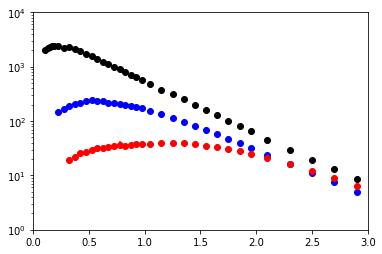

In [74]:
# measured pion, kaon, proton pt spectra
plt.errorbar(pt["pion"], dndpt["pion"], yerr=dndpt_err["pion"], fmt='o', color='black')
plt.errorbar(pt["kaon"], dndpt["kaon"], yerr=dndpt_err["kaon"], fmt='o', color='blue')
plt.errorbar(pt["proton"], dndpt["proton"], yerr=dndpt_err["proton"], fmt='o', color='red')
plt.xlim(0.,3.)
plt.ylim(1,1e4)
plt.yscale("log")

# your code here

# fit parameters
# Tkin = m.values['Tkin']
# beta_s = m.values['beta_s']
# n = m.values['n']

# normalization
# A_pion = normalization("pion", Tkin, beta_s, n)
# A_kaon = normalization("kaon", Tkin, beta_s, n)
# A_proton = normalization("proton", Tkin, beta_s, n)

# ...


g) Draw the $1\sigma$ error ellipse for the $T$ and $\beta_s$ with the aid of 'get_cov_ellipse'

In [75]:
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

In [76]:
# V = m.np_covariance()
# V_Tkin_betas = V[0:2, 0:2] # sub-matrix giving the covariance matrix for Tkin and beta 

# from matplotlib.patches import Ellipse
# fig, ax = plt.subplots()

# ...

# your code here